In [268]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [269]:
# Load the data
csv_path = './CrabAgePrediction.csv'
data = pd.read_csv(csv_path)

# load Features and Labels
# using x _features
# "Sex", "Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Age"
x_features = ["Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight", "Shell Weight"]
# to predict Age
y_target = ["Age"]

x = data[x_features]
y = data[y_target]

print(x.head())
print(y.head())

# load with torch
x_tensor = torch.tensor(x.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

   Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0  1.4375    1.1750  0.4125  24.635715       12.332033        5.584852   
1  0.8875    0.6500  0.2125   5.400580        2.296310        1.374951   
2  1.0375    0.7750  0.2500   7.952035        3.231843        1.601747   
3  1.1750    0.8875  0.2500  13.480187        4.748541        2.282135   
4  0.8875    0.6625  0.2125   6.903103        3.458639        1.488349   

   Shell Weight  
0      6.747181  
1      1.559222  
2      2.764076  
3      5.244657  
4      1.700970  
   Age
0    9
1    6
2    6
3   10
4    6


size of x_train: torch.Size([3114, 7])
size of x_test: torch.Size([779, 7])
size of y_train: torch.Size([3114, 1])
size of y_test: torch.Size([779, 1])


size of weights: torch.Size([7, 1])
size of pred_soln: torch.Size([779, 1])
size of y_test: torch.Size([779, 1])


MSE: 4.830881207760181
RMSE: 2.197926570147461


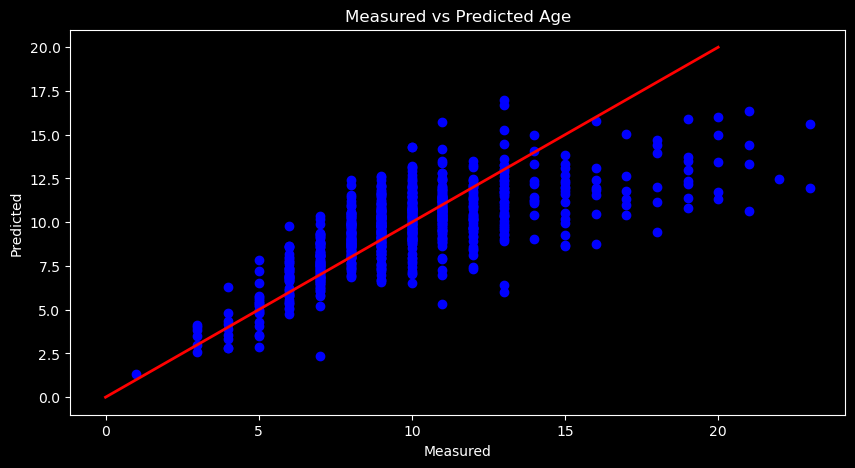

In [270]:
# Split the data into training and test sets
testing_fraction = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=testing_fraction, random_state=42)
print(f'size of x_train: {x_train.size()}')
print(f'size of x_test: {x_test.size()}')
print(f'size of y_train: {y_train.size()}')
print(f'size of y_test: {y_test.size()}\n\n')


# compute the pseudo-inverse
# (A^TA)^{-1}A^T
Pinv = torch.linalg.pinv(x_train)

# compute the weights
# x=((A^TA)^{-1}A^T)b
weights = Pinv @ y_train

print(f'size of weights: {weights.size()}')

# prediction is then A*x=b
# b is y_pred
y_pred = x_test @ weights

print(f'size of pred_soln: {y_pred.size()}')
print(f'size of y_test: {y_test.size()}\n\n')


# compute the mean squared error between the predicted and actual values

avg_MSE = mean_squared_error(y_test, y_pred)
print(f'MSE: {avg_MSE}')
# compute RMSE
RMSE = np.sqrt(avg_MSE)
print(f'RMSE: {RMSE}')

MSE_tensor = torch.nn.functional.mse_loss(y_test, y_pred, reduction='none')  # No reduction to get per-sample errors

plt.figure(figsize=(10, 5))
# plot predicted vs actual
plt.scatter(y_test, y_pred, color='blue')
# Fit a line to the data
plt.plot([0,20], [0,20], lw=2, color='red')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Age')
plt.show()

In [271]:
def gradient_descent(A, y, rate, epochs, loss):
    w = torch.rand((x_train.shape[1],1), dtype=torch.float32)
    for i in range(epochs):
        # compute the gradient
        diff = A @ w - y
        # grad = 2 * A.T @ A @ w - 2 * A.T @ y
        grad = 2 * A.T @ diff / A.shape[0]
        # update the weights
        w = w - rate * grad
        
        loss.append(torch.mean(diff ** 2))
        if i % 1000 == 0:
            print(f'Epoch {i}: Error = {loss[-1]}')
    return w

In [272]:
print("x_train", x_train.size())
print("y_train", y_train.size())
step_size = 0.00025
print("\n\n")
epochs = 10000

loss = []

rand_weights = gradient_descent(x_train, y_train, step_size, epochs, loss)


y_learned = x_test @ rand_weights


# compute the mean squared error between the predicted and actual values
avg_MSE = mean_squared_error(y_test, y_learned)
print(f'MSE: {avg_MSE}')
# compute RMSE
RMSE = np.sqrt(avg_MSE)
print(f'RMSE: {RMSE}')


x_train torch.Size([3114, 7])
y_train torch.Size([3114, 1])



Epoch 0: Error = 252.55181884765625
Epoch 1000: Error = 12.462851524353027
Epoch 2000: Error = 10.602197647094727
Epoch 3000: Error = 9.268498420715332
Epoch 4000: Error = 8.2703275680542
Epoch 5000: Error = 7.519588947296143
Epoch 6000: Error = 6.953683853149414
Epoch 7000: Error = 6.526341915130615
Epoch 8000: Error = 6.203135013580322
Epoch 9000: Error = 5.95835542678833
MSE: 5.541801158744367
RMSE: 2.3541030476052587


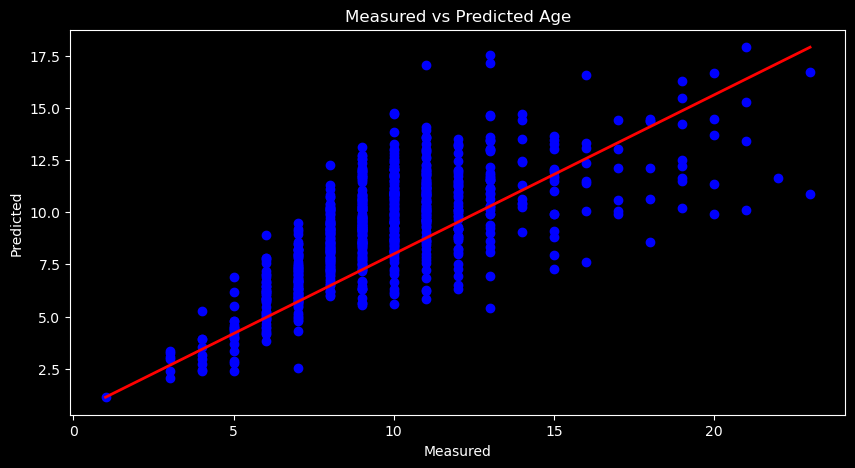

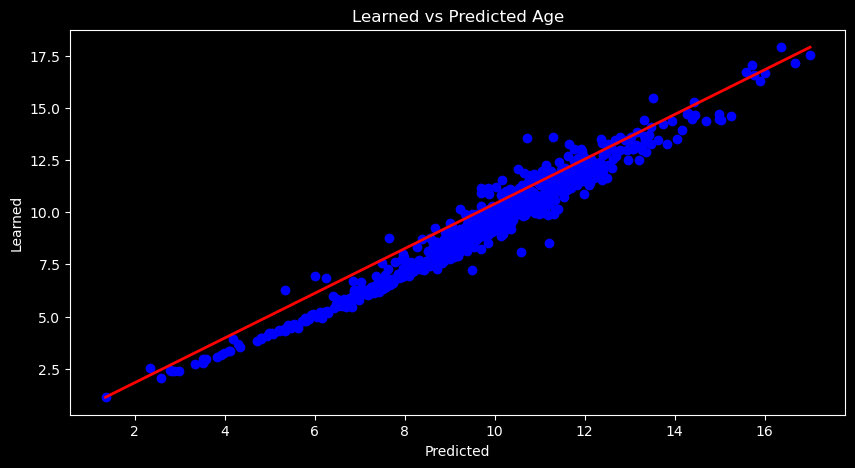

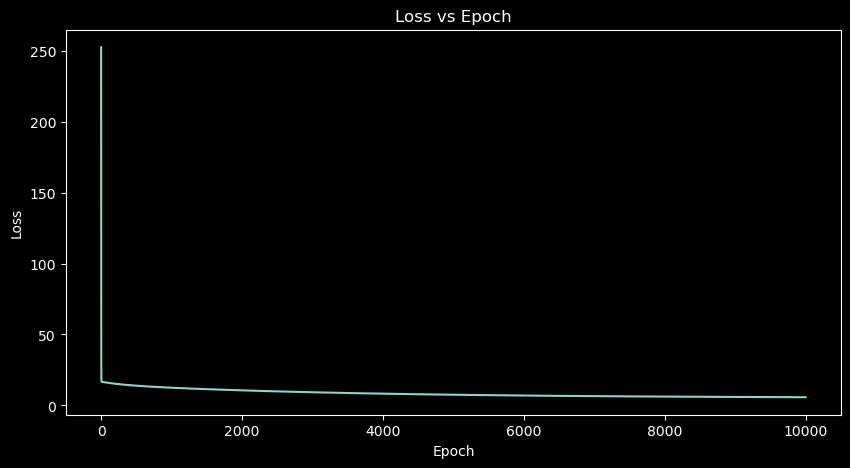

In [273]:

x_range = (min(y_test), max(y_test))
y_range = (min(y_learned), max(y_learned))
plt.figure(figsize=(10, 5))
# plot predicted vs actual
plt.scatter(y_test, y_learned, color='blue')
# Fit a line to the data
plt.plot(x_range, y_range, lw=2, color='red')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Age')

x_range = (min(y_pred), max(y_pred))
y_range = (min(y_learned), max(y_learned))
plt.figure(figsize=(10, 5))
# plot predicted vs actual
plt.scatter(y_pred, y_learned, color='blue')
# Fit a line to the data
plt.plot(x_range, y_range, lw=2, color='red')
plt.xlabel('Predicted')
plt.ylabel('Learned')
plt.title('Learned vs Predicted Age')

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()